In [54]:
import pandas as pd
import numpy as np
import pickle
from tabulate import tabulate
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import random 

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,roc_auc_score, classification_report, 
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, 
    HistGradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, ClassifierMixin

from interpret.glassbox import ExplainableBoostingClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli 
from snapml import BoostingMachineClassifier  
from pytorch_tabnet.tab_model import TabNetClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tab_transformer_pytorch import TabTransformer 
from tab_transformer_pytorch import FTTransformer

In [9]:
df = pd.read_csv('data/cleaned_data.csv')
cols_to_keep = ['age', 
                'height',
                'weight',
                'systolic', 
                'diastolic',
                'bmi',
                'map',
                'pulse_pressure',
                'gender',
                'cholesterol', 
                'gluc',
                'smoke', 
                'alco', 
                'active',
                'cardio'
                ]

df = df[cols_to_keep]

In [131]:
X = df.drop('cardio', axis=1)
y = df['cardio']

label_mapping = {0: 'Healthy', 1: 'Cardio Risk'}
target_names = [label_mapping[label] for label in y.unique()]

numerical_features = ['age', 'height', 'weight', 'systolic', 'diastolic', 'bmi', 'map', 'pulse_pressure']
ordinal_features = ['cholesterol', 'gluc']
binary_features = ['gender', 'smoke', 'alco', 'active']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Catatan: ColumnTransformer dengan remainder='passthrough' akan mengubah urutan kolom.
# Fitur yang discaling akan berada di awal, kemudian sisanya.
# Untuk mendapatkan nama kolom kembali (opsional), kita bisa menyusun ulang nama kolom sebagai berikut.
passthrough_features = [col for col in X.columns if col not in numerical_features]
transformed_feature_names = numerical_features + passthrough_features

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)
print("Contoh data train setelah scaling:")
print(X_train_transformed_df.head())

Contoh data train setelah scaling:
        age    height    weight  systolic  diastolic       bmi       map  \
0 -0.431181 -0.580958  0.227592 -0.448449  -0.219513  0.556238 -0.357337   
1  1.645896 -0.050963  0.146374 -0.448449  -1.522162  0.164370 -1.087684   
2 -1.766444  0.479031 -0.503370 -1.149304  -1.522162 -0.739102 -1.453955   
3 -1.469719  0.611530  1.933169  1.303690   1.734461  1.485835  1.653859   
4 -0.134455  1.009026  0.146374 -0.448449  -0.219513 -0.388598 -0.357337   

   pulse_pressure  gender  cholesterol  gluc  smoke  alco  active  
0       -0.453476     0.0          0.0   0.0    0.0   0.0     0.0  
1        0.508610     0.0          0.0   0.0    0.0   0.0     0.0  
2       -0.453476     0.0          0.0   0.0    0.0   0.0     1.0  
3        0.508610     1.0          0.0   0.0    1.0   1.0     1.0  
4       -0.453476     0.0          0.0   0.0    0.0   0.0     1.0  


In [132]:
x_train_np = np.array(X_train_transformed)
y_train_np = np.array(y_train)
x_test_np = np.array(X_test_transformed)
y_test_np = np.array(y_test)

In [128]:
# ————————————————————————————————
# 1) FIXED RANDOM SEED FOR REPRODUCIBILITY
# ————————————————————————————————
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False
torch.use_deterministic_algorithms(True)

# ————————————————————————————————
# 2) TABULAR DATASET
# ————————————————————————————————
class TabularDataset(Dataset):
    def __init__(self, X, categorical_indices, continuous_indices, targets):
        self.X = X
        self.categorical_indices = categorical_indices
        self.continuous_indices = continuous_indices
        self.targets = targets
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        row    = self.X[idx]
        x_cont = row[self.continuous_indices].astype(np.float32)
        x_cat  = row[self.categorical_indices].astype(np.int64)
        y      = np.array(self.targets[idx]).astype(np.float32)
        return x_cat, x_cont, y
# ————————————————————————————————
# 3) PYTORCH WRAPPER (sklearn API)
# ————————————————————————————————
class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self,
                model,
                epochs=None,
                lr=None,
                batch_size=None,
                device=None,
                continuous_indices=None,
                categorical_indices=None):
        self.model               = model
        self.epochs              = epochs
        self.lr                  = lr
        self.batch_size          = batch_size
        self.device              = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.continuous_indices  = continuous_indices
        self.categorical_indices = categorical_indices

    def fit(self, X, y):
        # A) Reseed at start of every fit
        random.seed(SEED)
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)

        if self.continuous_indices is None or self.categorical_indices is None:
            raise ValueError("continuous_indices & categorical_indices must be provided")

        ds = TabularDataset(X, self.categorical_indices, self.continuous_indices, y)

        # B) worker_init_fn for reproducible workers
        def seed_worker(worker_id):
            np.random.seed(SEED + worker_id)
            random.seed(SEED + worker_id)

        loader = DataLoader(
            ds,
            batch_size=self.batch_size,
            shuffle=True,
            generator=torch.Generator().manual_seed(SEED),
            worker_init_fn=seed_worker,
            num_workers=0
        )

        self.model.to(self.device)
        self.model.train()
        criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)

        for epoch in range(1, self.epochs+1):
            total_loss = 0.0
            for x_cat, x_cont, targets in loader:
                x_cat    = x_cat.to(self.device)
                x_cont   = x_cont.to(self.device)
                targets  = targets.to(self.device).unsqueeze(1)
                optimizer.zero_grad()
                outputs = self.model(x_cat, x_cont)
                loss    = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * x_cat.size(0)
            avg_loss = total_loss / len(loader.dataset)
            print(f"[Wrapper] Epoch {epoch}/{self.epochs}, Loss: {avg_loss:.4f}")
        return self

    def predict(self, X):
        self.model.eval()
        ds = TabularDataset(X, self.categorical_indices, self.continuous_indices, np.zeros(len(X)))
        loader = DataLoader(ds, batch_size=self.batch_size, shuffle=False)
        preds = []
        with torch.no_grad():
            for x_cat, x_cont, _ in loader:
                x_cat  = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                out    = self.model(x_cat, x_cont)
                prob   = torch.sigmoid(out).cpu().numpy()
                preds.append((prob >= 0.5).astype(int))
        return np.concatenate(preds).squeeze()

    def predict_proba(self, X):
        self.model.eval()
        ds = TabularDataset(X, self.categorical_indices, self.continuous_indices, np.zeros(len(X)))
        loader = DataLoader(ds, batch_size=self.batch_size, shuffle=False)
        probas = []
        with torch.no_grad():
            for x_cat, x_cont, _ in loader:
                x_cat  = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                out    = self.model(x_cat, x_cont)
                p      = torch.sigmoid(out).cpu().numpy().squeeze()
                probas.append(p)
        probas = np.concatenate(probas)
        return np.vstack([1-probas, probas]).T

# ————————————————————————————————
# 4) EVALUATION FUNCTION
# ————————————————————————————————
# 0) Two separate global histories
SUMMARY_HISTORY_TEST = []
SUMMARY_HISTORY_TRAIN = []

def evaluate_model(
    model, model_name="", 
    x_train=None, y_train=None, x_test=None, y_test=None,
    label_mapping=None, comparison_models=None,
    fit=False, summary=False  # summary flag
):
    """
    fit=True     -> call model.fit(x_train, y_train) internally
    fit=False    -> assume model already fitted outside
    summary=False-> save summary data without printing
    summary=True -> print cumulative summary table
    """
    # 1) Fit if requested
    if fit:
        model.fit(x_train, y_train)

    # 2) Predict & proba
    y_pred_train  = model.predict(x_train)
    y_pred_test   = model.predict(x_test)
    y_proba_train = model.predict_proba(x_train)[:, 1]
    y_proba_test  = model.predict_proba(x_test)[:, 1]

    # 3) Compute metrics
    metrics = {}
    for split, y_true, y_pred, y_probs in [
        ("Train", y_train, y_pred_train, y_proba_train),
        ("Test",  y_test,  y_pred_test,  y_proba_test)
    ]:
        metrics[f"{split}_Acc"]       = accuracy_score(y_true, y_pred)
        metrics[f"{split}_AUC"]       = roc_auc_score(y_true, y_probs)
        rpt = classification_report(y_true, y_pred, output_dict=True)
        metrics[f"{split}_Precision"] = rpt["weighted avg"]["precision"]
        metrics[f"{split}_Recall"]    = rpt["weighted avg"]["recall"]
        metrics[f"{split}_F1"]        = rpt["weighted avg"]["f1-score"]

    # 4) Print detailed reports (centered title)
    title = f"=== {model_name} Results ==="
    print("\n" + title.center(60))
    for split in ("Test", "Train"):
        print(f"{split} Acc: {metrics[f'{split}_Acc']:.4f}, AUC: {metrics[f'{split}_AUC']:.4f}")
        print(classification_report(
            y_test if split=="Test" else y_train,
            y_pred_test if split=="Test" else y_pred_train,
            digits=4
        ))
    print("✅ No significant overfitting\n" if not (
        metrics["Train_Acc"] > metrics["Test_Acc"] + 0.05 or
        metrics["Train_AUC"] > metrics["Test_AUC"] + 0.05
    ) else "⚠️ Overfitting suspected\n")

    # 5) Plot CM & ROC
    labels = list(label_mapping) if label_mapping is not None else None
    fig, axes = plt.subplots(2, 2, figsize=(12,10))

    def _plot_cm(ax, y_t, y_p, title):
        disp = ConfusionMatrixDisplay(confusion_matrix(y_t, y_p), display_labels=labels)
        disp.plot(ax=ax, values_format='d')
        ax.set_title(f"{model_name} – {title}")

    def _plot_roc(ax, y_t, y_p, title, auc_val):
        fpr, tpr, _ = roc_curve(y_t, y_p)
        ax.plot(fpr, tpr, label=f"AUC={auc_val:.4f}", linewidth=2)
        ax.plot([0,1],[0,1],'k--')
        ax.set_title(f"{model_name} – {title}")
        ax.legend(loc='lower right'); ax.grid(alpha=0.3)

    _plot_cm(axes[0,0], y_train, y_pred_train, "Confusion Matrix (Train)")
    _plot_roc(axes[0,1], y_train, y_proba_train, "ROC Curve (Train)", metrics["Train_AUC"])
    _plot_cm(axes[1,0], y_test,  y_pred_test,  "Confusion Matrix (Test)")
    _plot_roc(axes[1,1], y_test,  y_proba_test,  "ROC Curve (Test)",  metrics["Test_AUC"])
    plt.tight_layout(); plt.show()

    # 6) ROC Comparison (optional)
    if comparison_models:
        plt.figure(figsize=(8,6))
        for nm, m in comparison_models.items():
            pr = m.predict_proba(x_test)[:,1]
            f, t, _ = roc_curve(y_test, pr)
            a = roc_auc_score(y_test, pr)
            plt.plot(f, t, label=f"{nm} (AUC={a:.4f})", linewidth=2)
        f_main, t_main, _ = roc_curve(y_test, y_proba_test)
        plt.plot(f_main, t_main,
                label=f"{model_name} (AUC={metrics['Test_AUC']:.4f})",
                linewidth=2)
        plt.plot([0,1],[0,1],'k--', linewidth=1)
        plt.title("ROC Curve Comparison")
        plt.xlabel("False Positive Rate (FPR)"); plt.ylabel("True Positive Rate (TPR)");
        plt.grid(alpha=0.3)
        plt.legend(loc='lower right')
        plt.tight_layout(); plt.show()

    # 7) ALWAYS append to both histories
    SUMMARY_HISTORY_TEST.append({
        "Algorithm": model_name,
        "Accuracy":  metrics["Test_Acc"],
        "Precision": metrics["Test_Precision"],
        "Recall":    metrics["Test_Recall"],
        "F1-Score":  metrics["Test_F1"],
        "AUC":       metrics["Test_AUC"]
    })
    SUMMARY_HISTORY_TRAIN.append({
        "Algorithm": model_name,
        "Accuracy":  metrics["Train_Acc"],
        "Precision": metrics["Train_Precision"],
        "Recall":    metrics["Train_Recall"],
        "F1-Score":  metrics["Train_F1"],
        "AUC":       metrics["Train_AUC"]
    })

    # 8) Conditionally print cumulative summaries
    if summary:
        headers = ["Algorithm", "Accuracy", "Precision", "Recall", "F1-Score", "AUC"]

        # Test
        print("Cumulative Summary Table - Test Metrics")
        rows_test = [[d[h] for h in headers] for d in SUMMARY_HISTORY_TEST]
        print(tabulate(rows_test, headers, tablefmt="grid", floatfmt=".4f"))

        # Train
        print("\nCumulative Summary Table - Training Metrics")
        rows_train = [[d[h] for h in headers] for d in SUMMARY_HISTORY_TRAIN]
        print(tabulate(rows_train, headers, tablefmt="grid", floatfmt=".4f"))

    return metrics


                  === LightGBM Results ===                  
Test Acc: 0.7382, AUC: 0.8016
              precision    recall  f1-score   support

           0     0.7256    0.7755    0.7497      6321
           1     0.7530    0.7000    0.7255      6180

    accuracy                         0.7382     12501
   macro avg     0.7393    0.7378    0.7376     12501
weighted avg     0.7391    0.7382    0.7378     12501

Train Acc: 0.7440, AUC: 0.8187
              precision    recall  f1-score   support

           0     0.7290    0.7870    0.7569     25313
           1     0.7622    0.7000    0.7298     24688

    accuracy                         0.7440     50001
   macro avg     0.7456    0.7435    0.7433     50001
weighted avg     0.7454    0.7440    0.7435     50001

✅ No significant overfitting



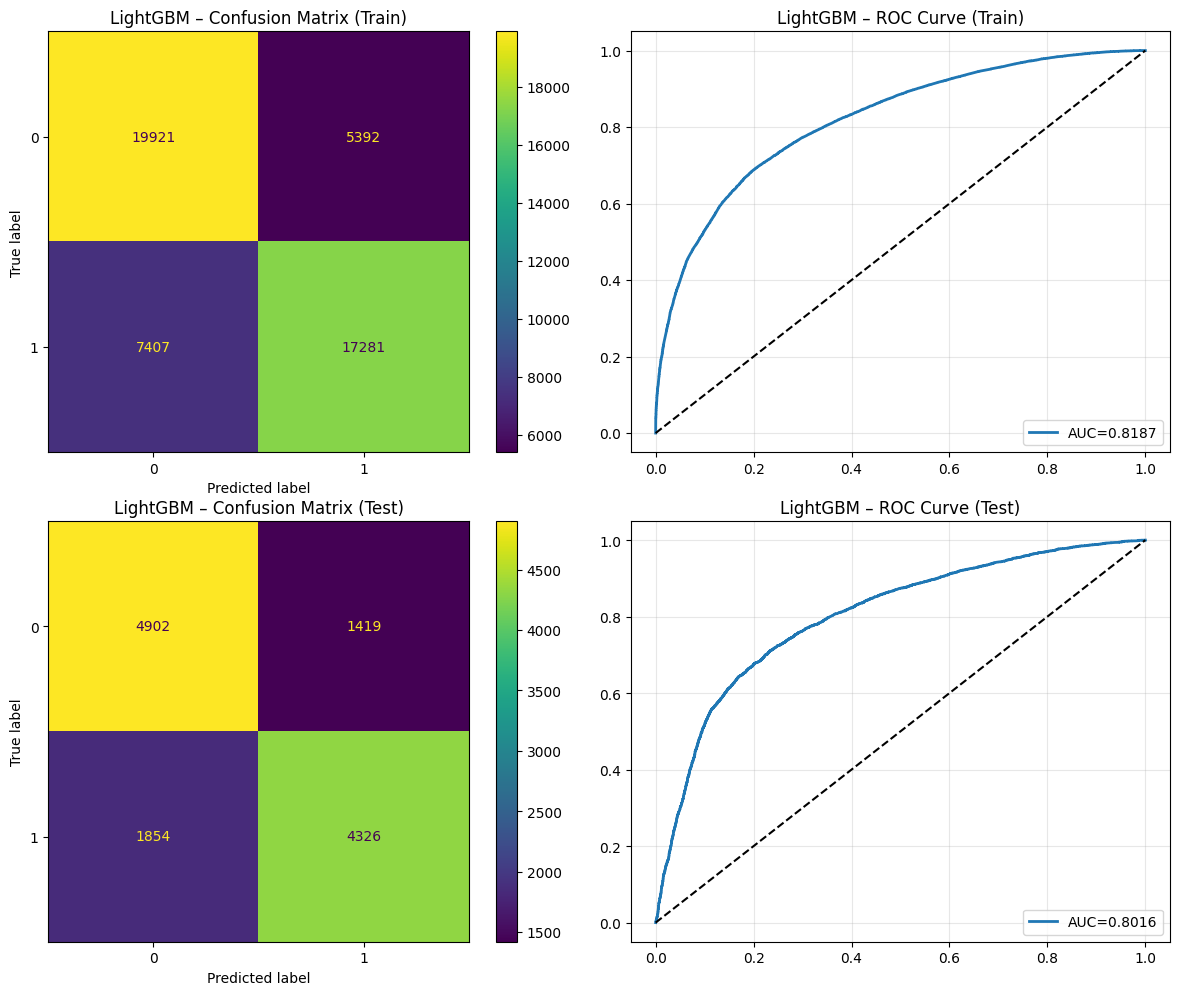

Cumulative Summary Table - Test Metrics
+-------------+------------+-------------+----------+------------+--------+
| Algorithm   |   Accuracy |   Precision |   Recall |   F1-Score |    AUC |
+=============+============+=============+==========+============+========+
| LightGBM    |     0.7382 |      0.7391 |   0.7382 |     0.7378 | 0.8016 |
+-------------+------------+-------------+----------+------------+--------+

Cumulative Summary Table - Training Metrics
+-------------+------------+-------------+----------+------------+--------+
| Algorithm   |   Accuracy |   Precision |   Recall |   F1-Score |    AUC |
+=============+============+=============+==========+============+========+
| LightGBM    |     0.7440 |      0.7454 |   0.7440 |     0.7435 | 0.8187 |
+-------------+------------+-------------+----------+------------+--------+


In [123]:

# best_params = {
#     'n_estimators': 233,
#     'learning_rate': 0.019519792757748358,
#     'num_leaves': 41,
#     'max_depth': 15,
#     'subsample': 0.758484089588373,
#     'colsample_bytree': 0.9592852139230149,
#     'random_state': 6580,
#     'verbose' : -1
# }

lgbm_model = LGBMClassifier(verbose=-1)

lgbm_model.fit(x_train_np, y_train_np)

lgbm_results = evaluate_model(
    model=lgbm_model,
    model_name="LightGBM",
    x_train=x_train_np,
    y_train=y_train_np,
    x_test=x_test_np,
    y_test=y_test_np,
    summary=True
)

lgbm_results;


                  === CatBoost Results ===                  
Test Acc: 0.7310, AUC: 0.7952
              precision    recall  f1-score   support

           0     0.7164    0.7756    0.7448      6327
           1     0.7487    0.6853    0.7156      6174

    accuracy                         0.7310     12501
   macro avg     0.7325    0.7304    0.7302     12501
weighted avg     0.7323    0.7310    0.7304     12501

Train Acc: 0.7551, AUC: 0.8320
              precision    recall  f1-score   support

           0     0.7369    0.8028    0.7684     25307
           1     0.7775    0.7062    0.7402     24694

    accuracy                         0.7551     50001
   macro avg     0.7572    0.7545    0.7543     50001
weighted avg     0.7570    0.7551    0.7545     50001

✅ No significant overfitting



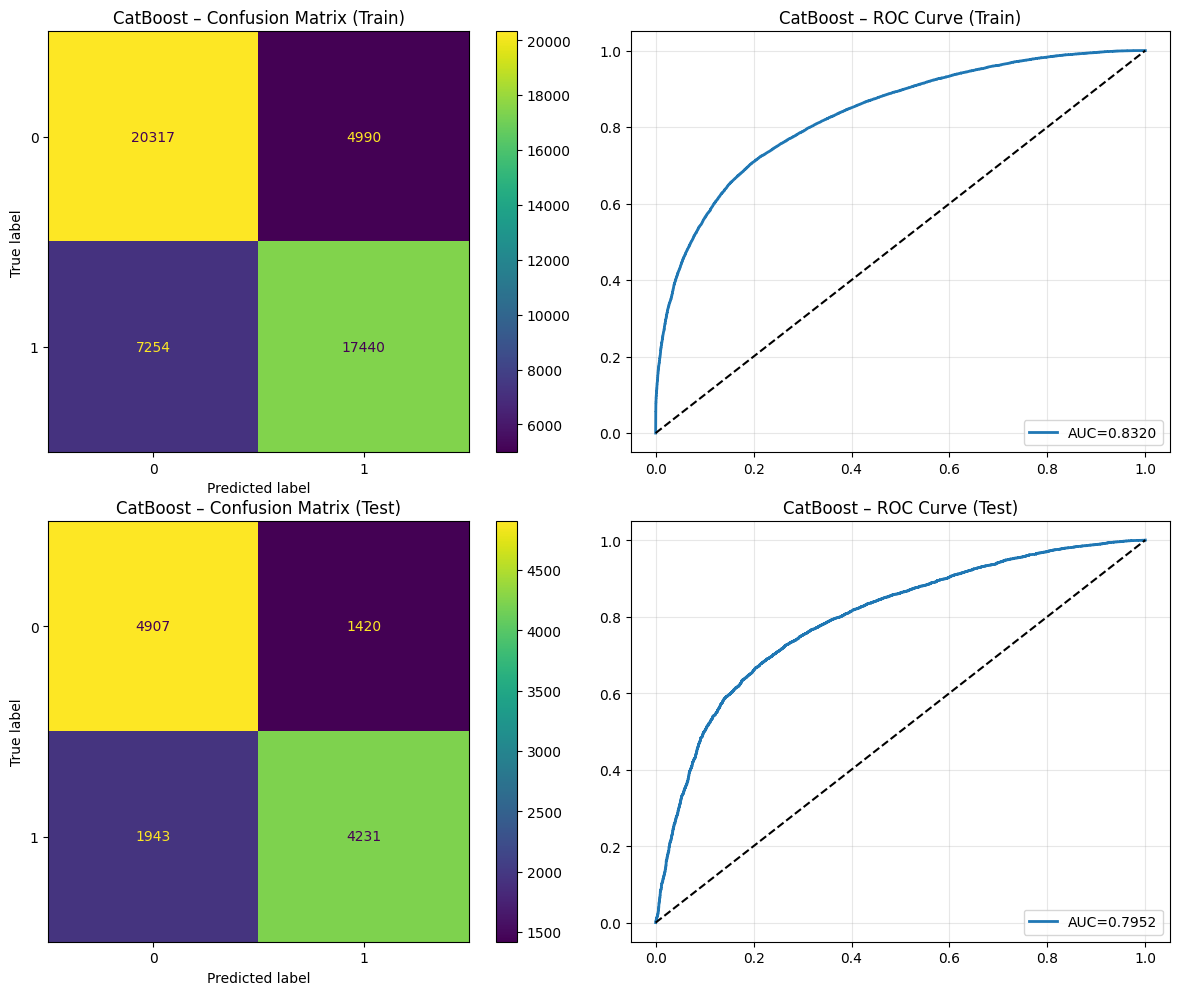

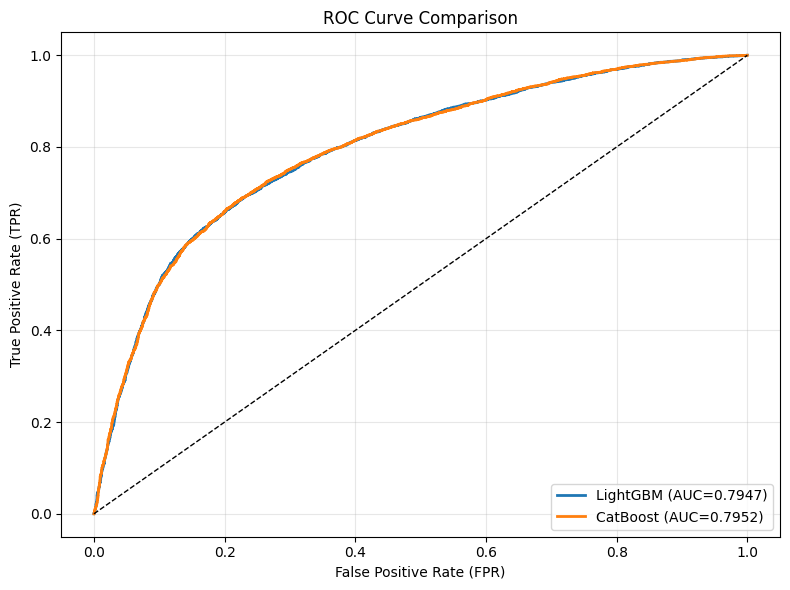

In [117]:
# best_params = {
#     'iterations': 680, 
#     'learning_rate': 0.01040286438048717, 
#     'depth': 9, 
#     'l2_leaf_reg': 0.10424693387826892, 
#     'border_count': 220, 
#     'random_strength': 0.015513247584661348, 
#     'bagging_temperature': 0.2020691195100053, 
#     'random_seed': 7801,
#     'verbose': False
#     }

catb_model = CatBoostClassifier(verbose=False)

catb_model.fit(x_train_np, y_train_np)

catb_results = evaluate_model(
    model= catb_model, 
    model_name="CatBoost", 
    x_train=x_train_np, 
    y_train=y_train_np, 
    x_test=x_test_np, 
    y_test=y_test_np,
    comparison_models={
        'LightGBM': lgbm_model
    }
)

catb_results;


           === Hist Gradient Boosting Results ===           
Test Acc: 0.7295, AUC: 0.7951
              precision    recall  f1-score   support

           0     0.7118    0.7824    0.7454      6327
           1     0.7518    0.6754    0.7115      6174

    accuracy                         0.7295     12501
   macro avg     0.7318    0.7289    0.7285     12501
weighted avg     0.7315    0.7295    0.7287     12501

Train Acc: 0.7391, AUC: 0.8115
              precision    recall  f1-score   support

           0     0.7206    0.7914    0.7544     25307
           1     0.7623    0.6856    0.7219     24694

    accuracy                         0.7391     50001
   macro avg     0.7415    0.7385    0.7381     50001
weighted avg     0.7412    0.7391    0.7383     50001

✅ No significant overfitting



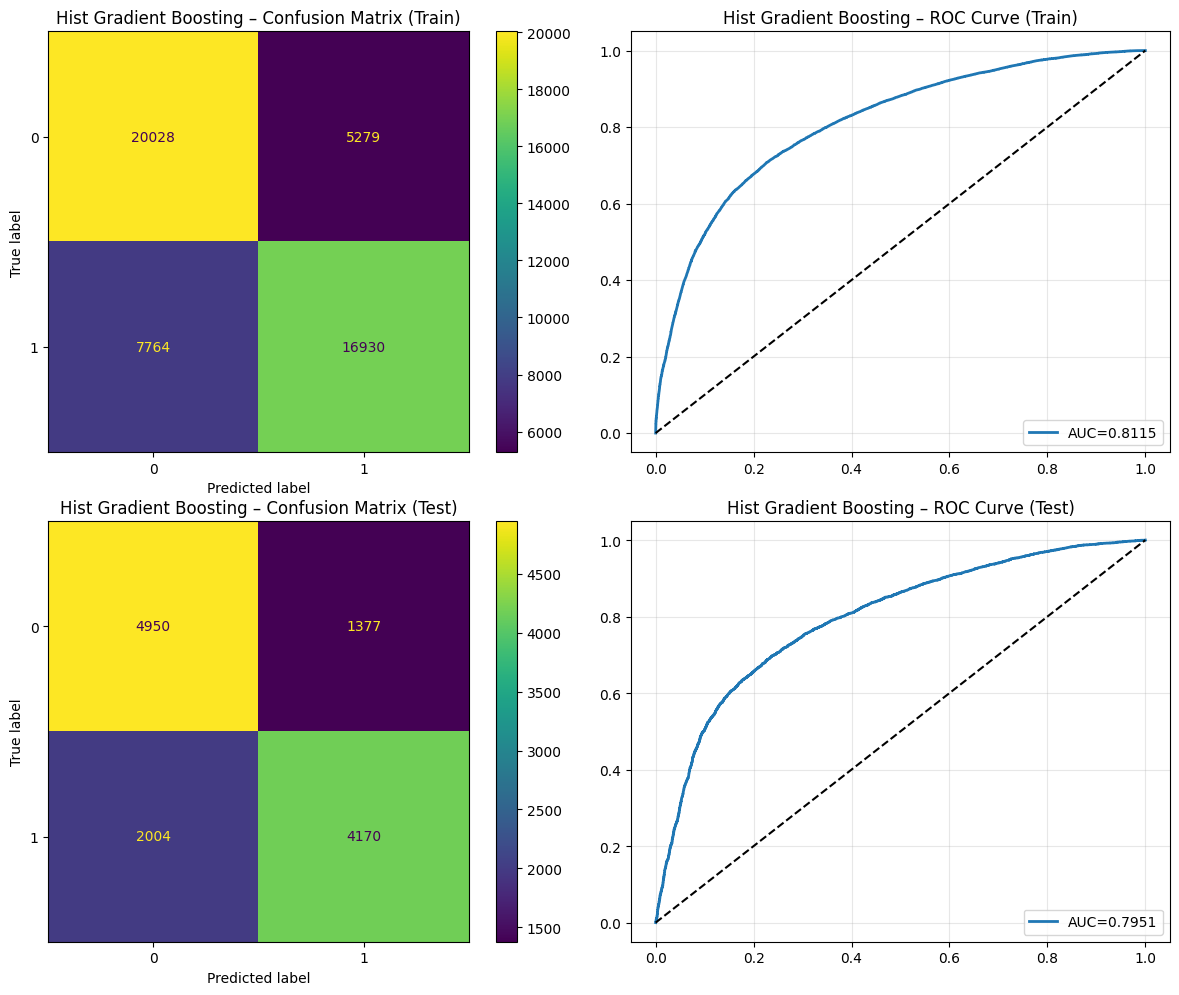

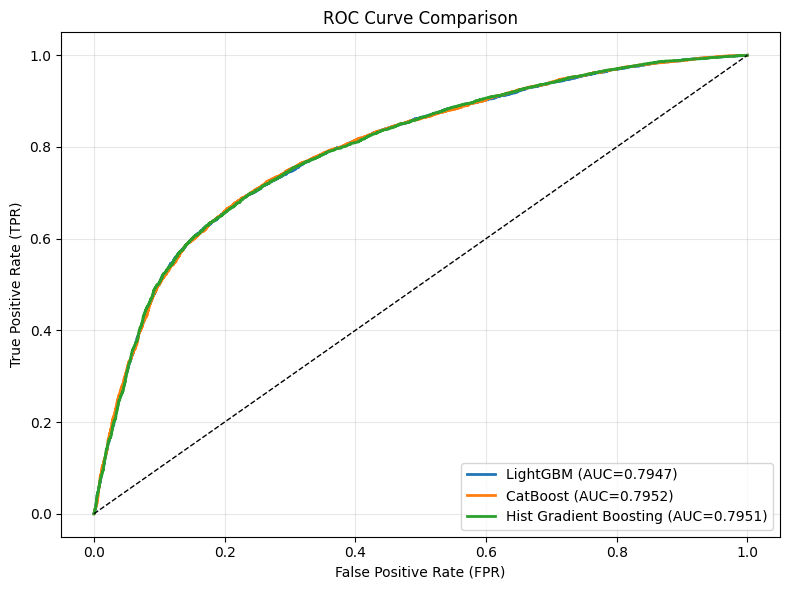

Cumulative Summary Table - Test Metrics
+------------------------+------------+-------------+----------+------------+--------+
| Algorithm              |   Accuracy |   Precision |   Recall |   F1-Score |    AUC |
+========================+============+=============+==========+============+========+
| LightGBM               |     0.7299 |      0.7317 |   0.7299 |     0.7292 | 0.7947 |
+------------------------+------------+-------------+----------+------------+--------+
| CatBoost               |     0.7310 |      0.7323 |   0.7310 |     0.7304 | 0.7952 |
+------------------------+------------+-------------+----------+------------+--------+
| Hist Gradient Boosting |     0.7295 |      0.7315 |   0.7295 |     0.7287 | 0.7951 |
+------------------------+------------+-------------+----------+------------+--------+

Cumulative Summary Table - Training Metrics
+------------------------+------------+-------------+----------+------------+--------+
| Algorithm              |   Accuracy |   Pre

In [118]:

# best_params = {
#     'max_iter': 409, 
#     'learning_rate': 0.01947652219796748, 
#     'max_leaf_nodes': 36, 
#     'min_samples_leaf': 28, 
#     'l2_regularization': 4.313378648780895e-06, 
#     'random_state': 8404
#             }

hgrb_model =  HistGradientBoostingClassifier(random_state=42)

hgrb_model.fit(x_train_np, y_train_np)

hgrb_results = evaluate_model(
    model= hgrb_model, 
    model_name="Hist Gradient Boosting", 
    x_train=x_train_np, 
    y_train=y_train_np, 
    x_test=x_test_np, 
    y_test=y_test_np,
    comparison_models={
        'LightGBM': lgbm_model,
        'CatBoost': catb_model
    },
    summary=True
)

hgrb_results;

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



                  === AdaBoost Results ===                  
Test Acc: 0.7257, AUC: 0.7889
              precision    recall  f1-score   support

           0     0.6998    0.8021    0.7475      6327
           1     0.7615    0.6474    0.6998      6174

    accuracy                         0.7257     12501
   macro avg     0.7306    0.7248    0.7236     12501
weighted avg     0.7303    0.7257    0.7239     12501

Train Acc: 0.7256, AUC: 0.7911
              precision    recall  f1-score   support

           0     0.6992    0.8038    0.7478     25307
           1     0.7625    0.6455    0.6992     24694

    accuracy                         0.7256     50001
   macro avg     0.7308    0.7247    0.7235     50001
weighted avg     0.7304    0.7256    0.7238     50001

✅ No significant overfitting



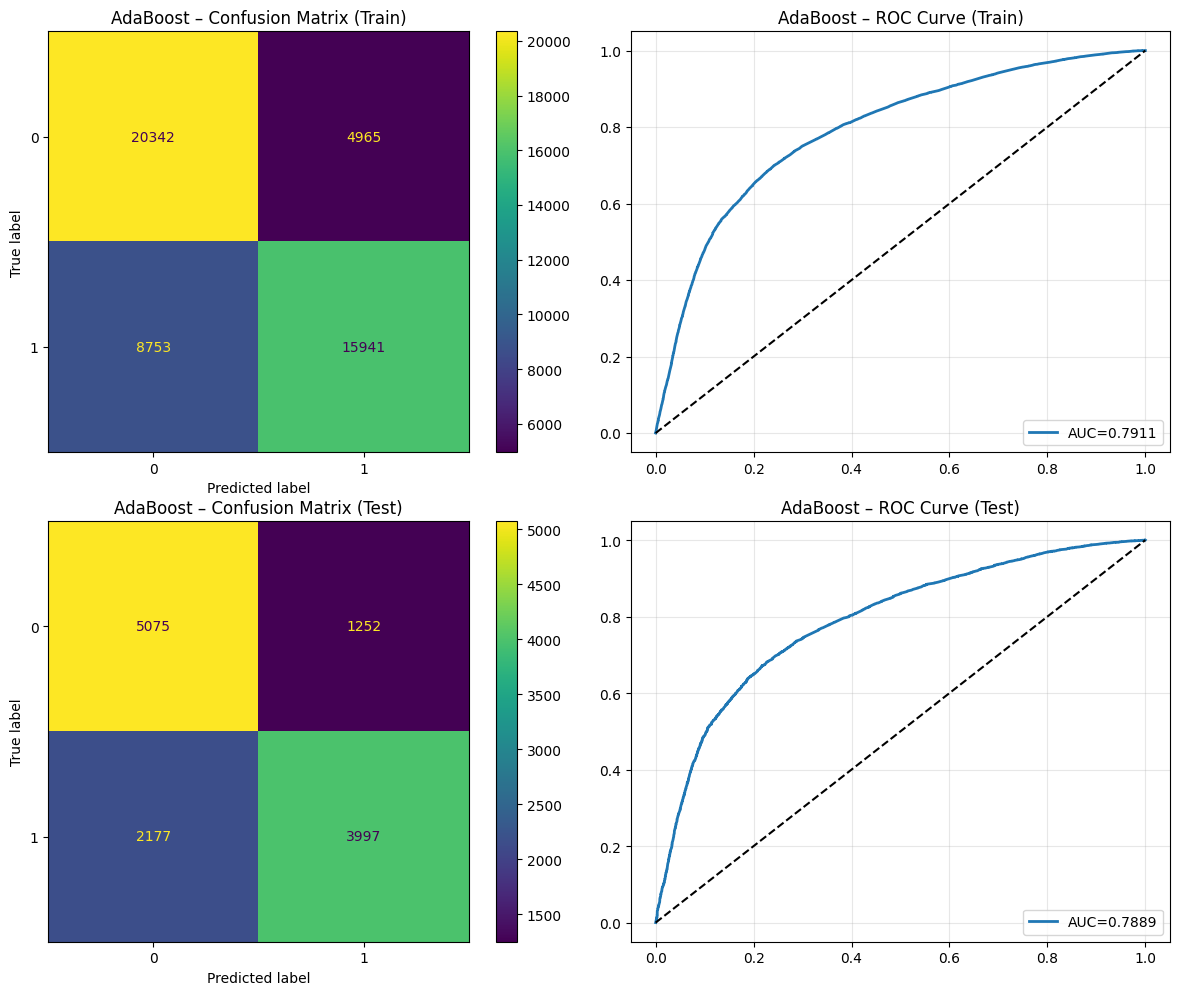

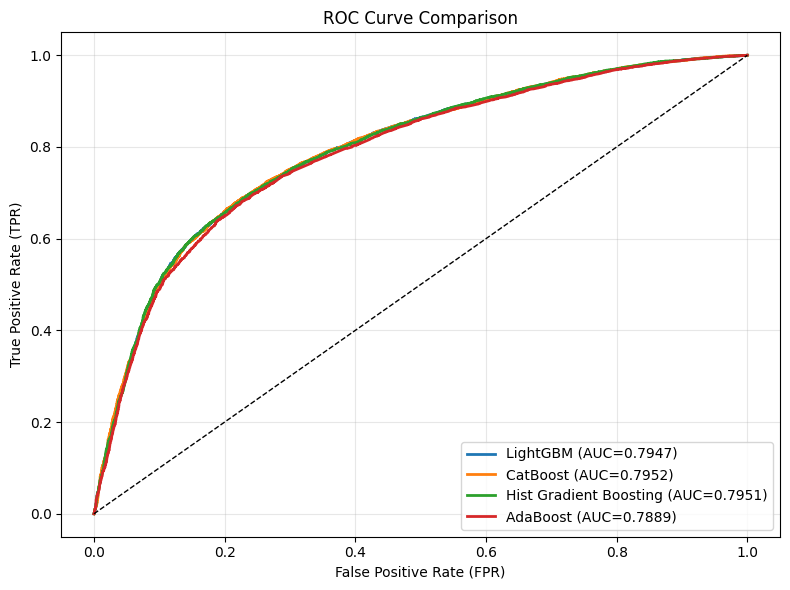

Cumulative Summary Table - Test Metrics
+------------------------+------------+-------------+----------+------------+--------+
| Algorithm              |   Accuracy |   Precision |   Recall |   F1-Score |    AUC |
+========================+============+=============+==========+============+========+
| LightGBM               |     0.7299 |      0.7317 |   0.7299 |     0.7292 | 0.7947 |
+------------------------+------------+-------------+----------+------------+--------+
| CatBoost               |     0.7310 |      0.7323 |   0.7310 |     0.7304 | 0.7952 |
+------------------------+------------+-------------+----------+------------+--------+
| Hist Gradient Boosting |     0.7295 |      0.7315 |   0.7295 |     0.7287 | 0.7951 |
+------------------------+------------+-------------+----------+------------+--------+
| AdaBoost               |     0.7257 |      0.7303 |   0.7257 |     0.7239 | 0.7889 |
+------------------------+------------+-------------+----------+------------+--------+

Cu

In [119]:
# best_params = {'n_estimators': 478, 'learning_rate': 0.17278746878628695, 'random_state': 5660}

adb_model = AdaBoostClassifier()

adb_model.fit(x_train_np, y_train_np)

adb_results = evaluate_model(
    model= adb_model, 
    model_name="AdaBoost", 
    x_train=x_train_np, 
    y_train=y_train_np, 
    x_test=x_test_np, 
    y_test=y_test_np,
    comparison_models={
        'LightGBM': lgbm_model,
        'CatBoost': catb_model,
        'Hist Gradient Boosting' : hgrb_model
    },
    summary=True
)

adb_results;

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)



                   === TabNet Results ===                   
Test Acc: 0.7382, AUC: 0.8006
              precision    recall  f1-score   support

           0     0.7237    0.7801    0.7508      6321
           1     0.7556    0.6953    0.7242      6180

    accuracy                         0.7382     12501
   macro avg     0.7396    0.7377    0.7375     12501
weighted avg     0.7394    0.7382    0.7377     12501

Train Acc: 0.7330, AUC: 0.7995
              precision    recall  f1-score   support

           0     0.7176    0.7794    0.7472     25313
           1     0.7519    0.6854    0.7171     24688

    accuracy                         0.7330     50001
   macro avg     0.7347    0.7324    0.7322     50001
weighted avg     0.7345    0.7330    0.7324     50001

✅ No significant overfitting



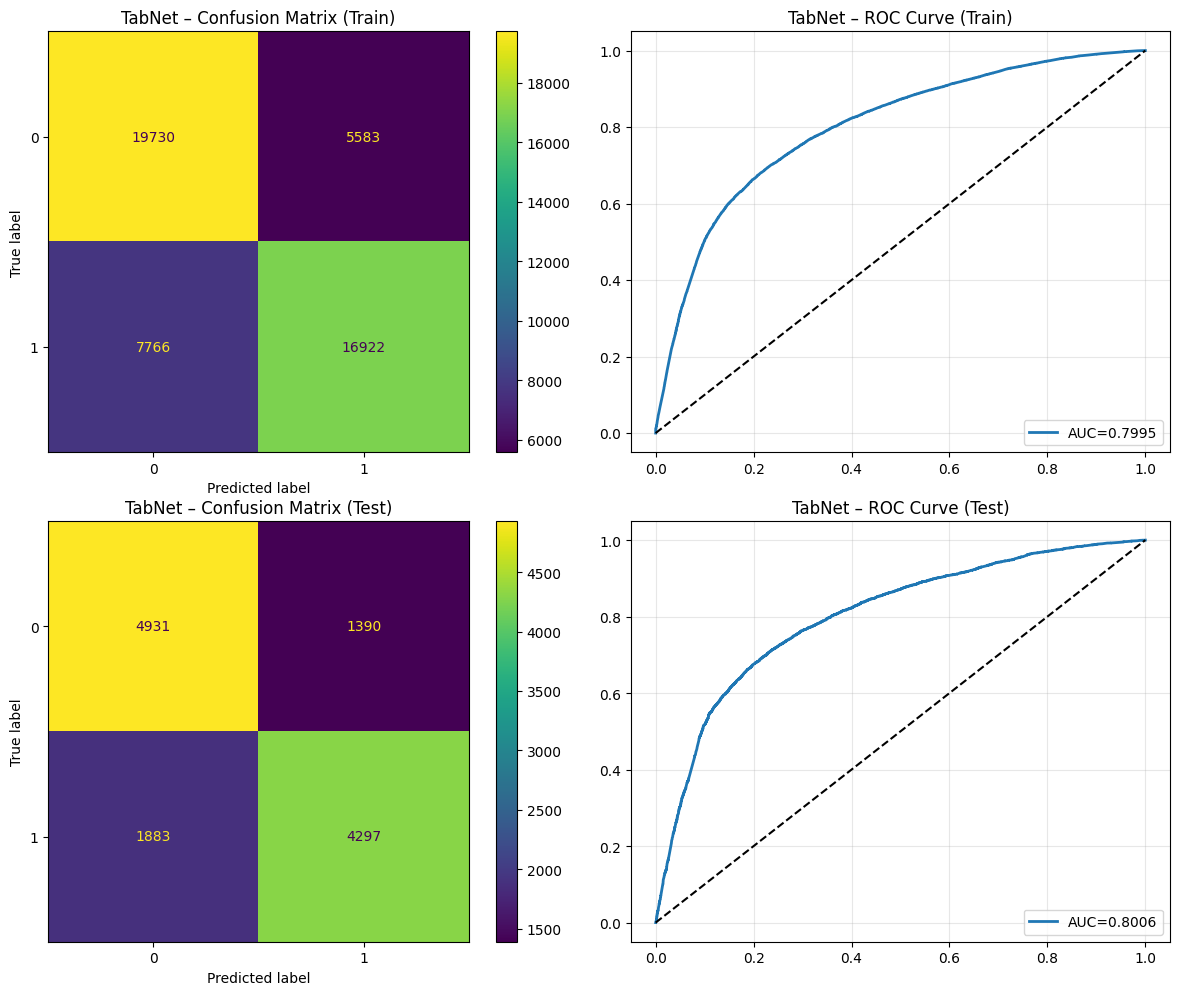

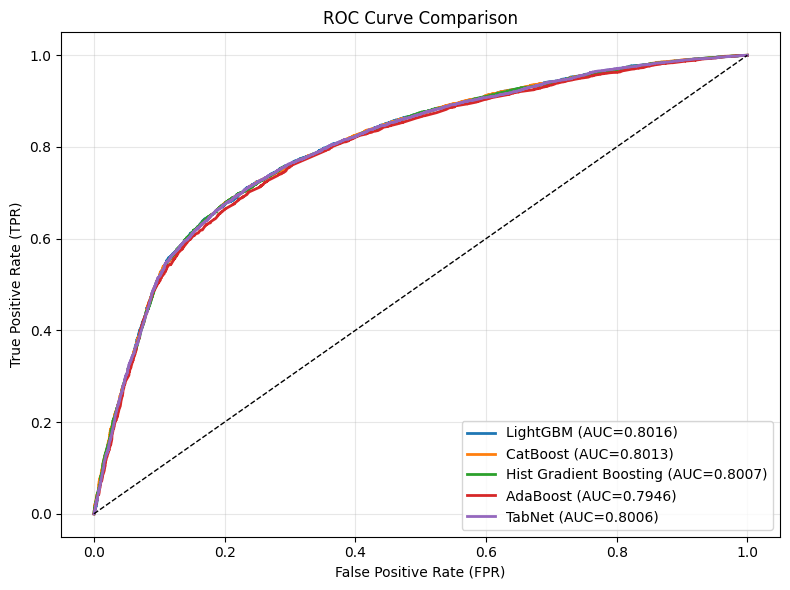

Cumulative Summary Table - Test Metrics
+------------------------+------------+-------------+----------+------------+--------+
| Algorithm              |   Accuracy |   Precision |   Recall |   F1-Score |    AUC |
+========================+============+=============+==========+============+========+
| LightGBM               |     0.7382 |      0.7391 |   0.7382 |     0.7378 | 0.8016 |
+------------------------+------------+-------------+----------+------------+--------+
| CatBoost               |     0.7379 |      0.7389 |   0.7379 |     0.7375 | 0.8013 |
+------------------------+------------+-------------+----------+------------+--------+
| Hist Gradient Boosting |     0.7372 |      0.7380 |   0.7372 |     0.7369 | 0.8007 |
+------------------------+------------+-------------+----------+------------+--------+
| AdaBoost               |     0.7320 |      0.7369 |   0.7320 |     0.7303 | 0.7946 |
+------------------------+------------+-------------+----------+------------+--------+
| T

In [107]:
tabnet_model = TabNetClassifier(verbose=0)

tabnet_model.fit(x_train_np, y_train_np)

tabnet_results = evaluate_model(
    model= tabnet_model, 
    model_name="TabNet", 
    x_train=x_train_np, 
    y_train=y_train_np, 
    x_test=x_test_np, 
    y_test=y_test_np,
    comparison_models={
        'LightGBM': lgbm_model,
        'CatBoost': catb_model,
        'Hist Gradient Boosting' : hgrb_model,
        'AdaBoost': adb_model
    },
    summary=True
)

tabnet_results;

In [19]:
continuous_indices = list(range(len(numerical_features)))  
categorical_indices = list(range(len(numerical_features), len(transformed_feature_names)))  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
tabtf_model = TabTransformer(
    categories            = (3, 3, 2, 2, 2, 2), 
    num_continuous        = len(continuous_indices),
    dim                   = 32,
    dim_out               = 1,
    depth                 = 6,
    heads                 = 8,
    attn_dropout          = 0.1,
    ff_dropout            = 0.1,
    mlp_hidden_mults      = (4, 2),
    mlp_act               = nn.ReLU(),
    continuous_mean_std   = None
).to(device)


tabtf_wrapper = PyTorchClassifier(
    model                 = tabtf_model,
    epochs                = 10,
    batch_size            = 64,
    lr                    = 1e-3,
    categorical_indices   = list(range(len(numerical_features), len(transformed_feature_names))),
    continuous_indices    = list(range(len(numerical_features)))
)


tabtf_results = evaluate_model(
    model                 = tabtf_model,
    model_name            = "TabTransformer",
    framework             = "pytorch",
    x_train               = x_train_np,
    y_train               = y_train_np,
    x_test                = x_test_np,
    y_test                = y_test_np,
    dataset_cls           = TabularDataset,
    categorical_indices   = categorical_indices,
    continuous_indices    = continuous_indices,
    batch_size            = 64,
    epochs                = 10,
    lr                    = 1e-3
    )

tabtf_results;

KeyboardInterrupt: 

[Wrapper] Epoch 1/10, Loss: 0.5583
[Wrapper] Epoch 2/10, Loss: 0.5510
[Wrapper] Epoch 3/10, Loss: 0.5505
[Wrapper] Epoch 4/10, Loss: 0.5492
[Wrapper] Epoch 5/10, Loss: 0.5487
[Wrapper] Epoch 6/10, Loss: 0.5481
[Wrapper] Epoch 7/10, Loss: 0.5474
[Wrapper] Epoch 8/10, Loss: 0.5476
[Wrapper] Epoch 9/10, Loss: 0.5480
[Wrapper] Epoch 10/10, Loss: 0.5469

               === FT-Transformer Results ===               
Test Acc: 0.7292, AUC: 0.7956
              precision    recall  f1-score   support

           0     0.7227    0.7545    0.7383      6327
           1     0.7366    0.7033    0.7195      6174

    accuracy                         0.7292     12501
   macro avg     0.7296    0.7289    0.7289     12501
weighted avg     0.7295    0.7292    0.7290     12501

Train Acc: 0.7334, AUC: 0.7989
              precision    recall  f1-score   support

           0     0.7255    0.7612    0.7429     25307
           1     0.7423    0.7049    0.7231     24694

    accuracy                       

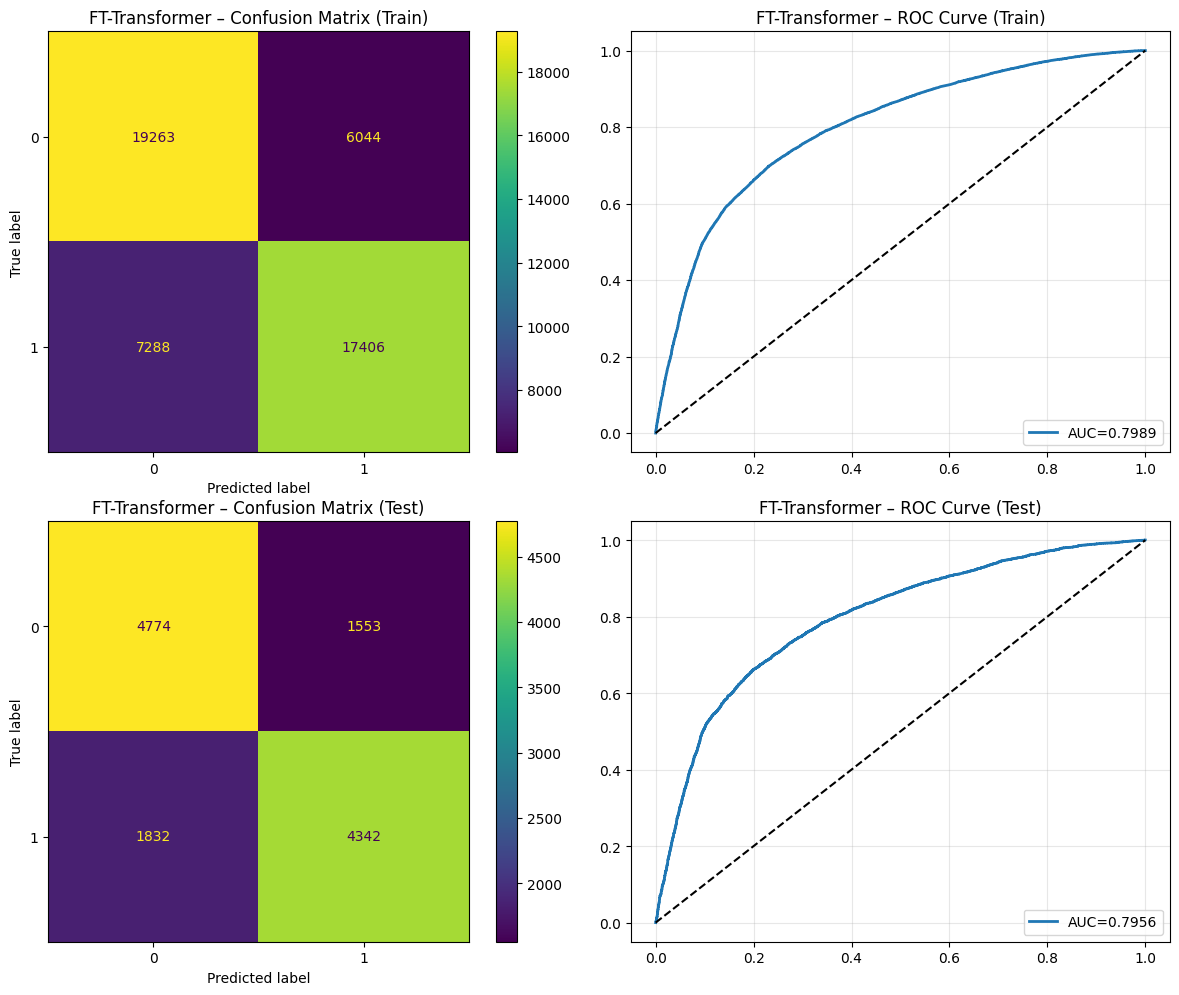

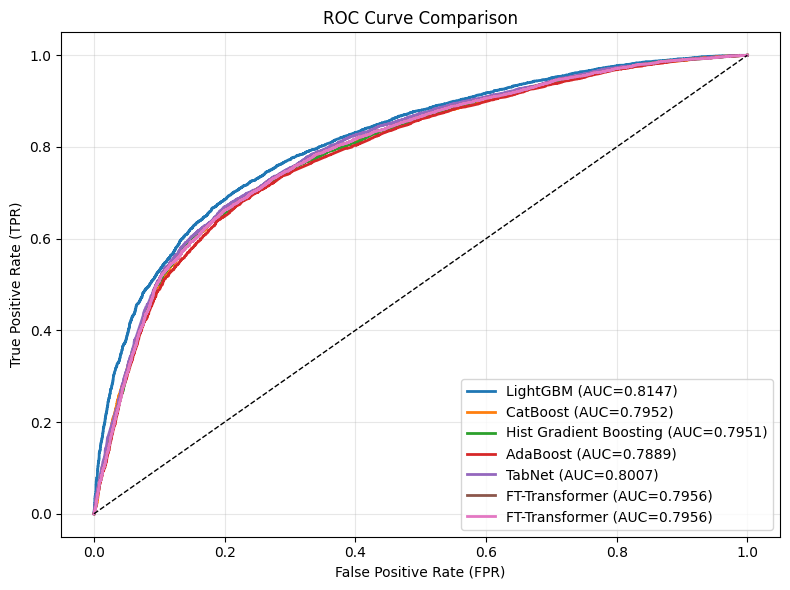

Cumulative Summary Table - Test Metrics
+----------------+------------+-------------+----------+------------+--------+
| Algorithm      |   Accuracy |   Precision |   Recall |   F1-Score |    AUC |
+================+============+=============+==========+============+========+
| FT-Transformer |     0.7274 |      0.7276 |   0.7274 |     0.7272 | 0.7958 |
+----------------+------------+-------------+----------+------------+--------+
| FT-Transformer |     0.7292 |      0.7295 |   0.7292 |     0.7290 | 0.7956 |
+----------------+------------+-------------+----------+------------+--------+

Cumulative Summary Table - Training Metrics
+----------------+------------+-------------+----------+------------+--------+
| Algorithm      |   Accuracy |   Precision |   Recall |   F1-Score |    AUC |
+================+============+=============+==========+============+========+
| FT-Transformer |     0.7322 |      0.7325 |   0.7322 |     0.7320 | 0.7989 |
+----------------+------------+-------------+-

In [130]:
fttf_model = FTTransformer(
    categories          = (3, 3, 2, 2, 2, 2), 
    num_continuous      = len(continuous_indices),
    dim                 = 32,
    dim_out             = 1,
    depth               = 6,
    heads               = 8,
    attn_dropout        = 0.1,
    ff_dropout          = 0.1
).to(device)

fttf_wrapper = PyTorchClassifier(
    model               = fttf_model,
    epochs              = 10,
    batch_size          = 32,
    lr                  = 1e-3,
    categorical_indices = categorical_indices,
    continuous_indices  = continuous_indices,
)

fttf_wrapper.fit(x_train_np, y_train_np)

fttf_results = evaluate_model(
    model               = fttf_wrapper,
    model_name          = "FT-Transformer",
    x_train             = x_train_np,
    y_train             = y_train_np,
    x_test              = x_test_np,
    y_test              = y_test_np,
    comparison_models   = {
                            'LightGBM': lgbm_model,
                            'CatBoost': catb_model,
                            'Hist Gradient Boosting' : hgrb_model,
                            'AdaBoost': adb_model,
                            'TabNet' : tabnet_model,
                            'FT-Transformer': fttf_wrapper
                        },
    summary             = True
    )

fttf_results;

In [22]:
base_models_ml = [
    ('lgbm', lgbm_model),
    ('cat', catb_model),
    ('hgrb', hgrb_model)
]

base_models_dl = [
    ('tabnet', tabnet_model),
    ('tabtf', tabtf_wrapper),
    ('fttf', fttf_wrapper)
]

base_models_el = [
    ('lgbm', lgbm_model),
    ('cat', catb_model),
    ('hgrb', hgrb_model),
    ('tabnet', tabnet_model),
    ('tabtf',tabtf_wrapper),
    ('fttf', fttf_wrapper)
]

In [23]:
meta_model = adb_model

In [24]:
stacking_model_ml = StackingClassifier(estimators=base_models_ml,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

stacking_model_dl = StackingClassifier(estimators=base_models_dl,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

stacking_model_el = StackingClassifier(estimators=base_models_el,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

In [25]:
stacking_model_ml.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('lgbm', LGBMClassifier(verbose=-1)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x7e9ab01a3bb0>),
                               ('hgrb',
                                HistGradientBoostingClassifier(random_state=42))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)


=== Stacking ML Model Results ===
Test   Acc: 0.7385, AUC: 0.7999
              precision    recall  f1-score   support

           0     0.7138    0.8060    0.7571      6321
           1     0.7714    0.6694    0.7168      6180

    accuracy                         0.7385     12501
   macro avg     0.7426    0.7377    0.7370     12501
weighted avg     0.7423    0.7385    0.7372     12501

Train   Acc: 0.7487, AUC: 0.8163
              precision    recall  f1-score   support

           0     0.7207    0.8223    0.7682     25313
           1     0.7871    0.6732    0.7257     24688

    accuracy                         0.7487     50001
   macro avg     0.7539    0.7478    0.7469     50001
weighted avg     0.7535    0.7487    0.7472     50001

✅ No significant overfitting



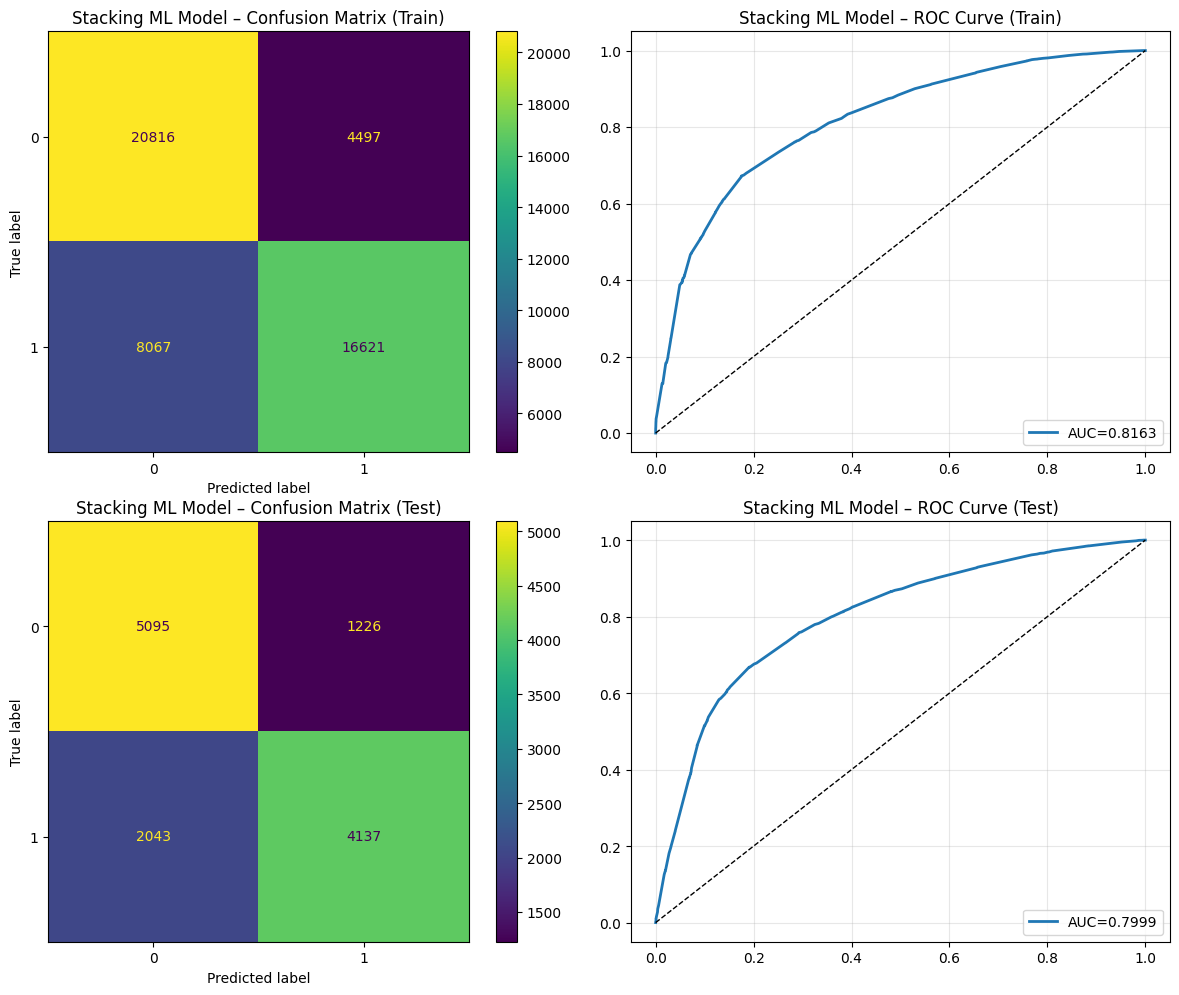

In [26]:
stacking_model_ml_results = evaluate_model(
    model=stacking_model_ml,
    x_train=x_train_np, y_train=y_train_np,
    x_test=x_test_np,  y_test =y_test_np,
    model_name='Stacking ML Model',
    label_mapping=label_mapping
)

stacking_model_ml_results;

In [27]:
stacking_model_dl.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


[Wrapper] Epoch 1/10, Loss: 0.5499
[Wrapper] Epoch 2/10, Loss: 0.5493
[Wrapper] Epoch 3/10, Loss: 0.5485
[Wrapper] Epoch 4/10, Loss: 0.5487
[Wrapper] Epoch 5/10, Loss: 0.5481
[Wrapper] Epoch 6/10, Loss: 0.5473
[Wrapper] Epoch 7/10, Loss: 0.5473
[Wrapper] Epoch 8/10, Loss: 0.5455
[Wrapper] Epoch 9/10, Loss: 0.5448
[Wrapper] Epoch 10/10, Loss: 0.5451
[Wrapper] Epoch 1/10, Loss: 0.5612
[Wrapper] Epoch 2/10, Loss: 0.5533
[Wrapper] Epoch 3/10, Loss: 0.5517
[Wrapper] Epoch 4/10, Loss: 0.5503
[Wrapper] Epoch 5/10, Loss: 0.5501
[Wrapper] Epoch 6/10, Loss: 0.5495
[Wrapper] Epoch 7/10, Loss: 0.5490
[Wrapper] Epoch 8/10, Loss: 0.5488
[Wrapper] Epoch 9/10, Loss: 0.5480
[Wrapper] Epoch 10/10, Loss: 0.5480


/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/sit

[Wrapper] Epoch 1/10, Loss: 0.5501
[Wrapper] Epoch 2/10, Loss: 0.5487
[Wrapper] Epoch 3/10, Loss: 0.5487
[Wrapper] Epoch 4/10, Loss: 0.5473
[Wrapper] Epoch 5/10, Loss: 0.5462
[Wrapper] Epoch 6/10, Loss: 0.5453
[Wrapper] Epoch 7/10, Loss: 0.5449
[Wrapper] Epoch 8/10, Loss: 0.5436
[Wrapper] Epoch 9/10, Loss: 0.5426
[Wrapper] Epoch 10/10, Loss: 0.5418
[Wrapper] Epoch 1/10, Loss: 0.5489
[Wrapper] Epoch 2/10, Loss: 0.5477
[Wrapper] Epoch 3/10, Loss: 0.5483
[Wrapper] Epoch 4/10, Loss: 0.5467
[Wrapper] Epoch 5/10, Loss: 0.5456
[Wrapper] Epoch 6/10, Loss: 0.5451
[Wrapper] Epoch 7/10, Loss: 0.5449
[Wrapper] Epoch 8/10, Loss: 0.5433
[Wrapper] Epoch 9/10, Loss: 0.5451
[Wrapper] Epoch 10/10, Loss: 0.5430
[Wrapper] Epoch 1/10, Loss: 0.5516
[Wrapper] Epoch 2/10, Loss: 0.5515
[Wrapper] Epoch 3/10, Loss: 0.5545
[Wrapper] Epoch 4/10, Loss: 0.5508
[Wrapper] Epoch 5/10, Loss: 0.5487
[Wrapper] Epoch 6/10, Loss: 0.5472
[Wrapper] Epoch 7/10, Loss: 0.5468
[Wrapper] Epoch 8/10, Loss: 0.5455
[Wrapper] Epoch 9/

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('tabnet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lambda_sparse=0.001,
                                                 seed=0,
                                                 clip_value=1,
                                                 verbose=0,
                                                 optimizer_fn=<class 'torch.optim.adam.Adam'>,
                                                 optimizer_params={'lr': 0.02},
                                                 scheduler_fn=None,
                                                 scheduler_params={},...
            (4): Linear(in_features=128, out_features=32, bias=True)
          )
          (act): Tanh()
          (norm): RMSNorm()
          (dropout): Dropout(p=0.0, inplace=False)
          (residual_transform): Identity()
        )
      )
    )
  )
  (to_logits): Sequential(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)


=== Stacking DL Model Results ===
Test   Acc: 0.7375, AUC: 0.8018
              precision    recall  f1-score   support

           0     0.7022    0.8347    0.7628      6321
           1     0.7905    0.6380    0.7061      6180

    accuracy                         0.7375     12501
   macro avg     0.7464    0.7364    0.7344     12501
weighted avg     0.7459    0.7375    0.7348     12501

Train   Acc: 0.7287, AUC: 0.8019
              precision    recall  f1-score   support

           0     0.6938    0.8306    0.7561     25313
           1     0.7823    0.6241    0.6943     24688

    accuracy                         0.7287     50001
   macro avg     0.7381    0.7274    0.7252     50001
weighted avg     0.7375    0.7287    0.7256     50001

✅ No significant overfitting



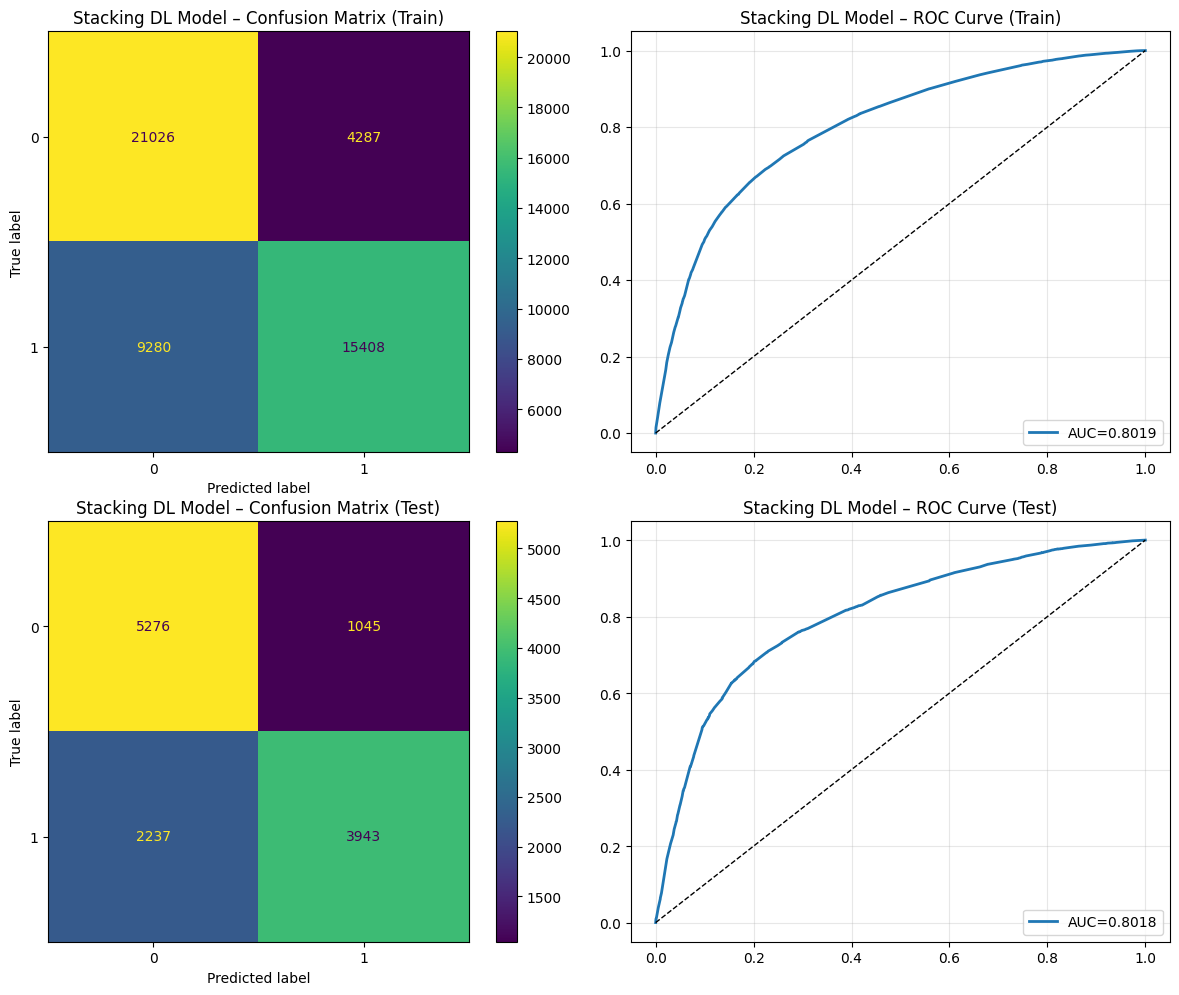

In [28]:
stacking_model_dl_results = evaluate_model(
    model=stacking_model_dl,
    x_train=x_train_np, y_train=y_train_np,
    x_test =x_test_np,  y_test =y_test_np,
    model_name='Stacking DL Model',
    label_mapping=label_mapping,
    categorical_indices=categorical_indices,
    continuous_indices=continuous_indices,
)


stacking_model_dl_results;


In [29]:
stacking_model_el.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


[Wrapper] Epoch 1/10, Loss: 0.5499
[Wrapper] Epoch 2/10, Loss: 0.5493
[Wrapper] Epoch 3/10, Loss: 0.5485
[Wrapper] Epoch 4/10, Loss: 0.5487
[Wrapper] Epoch 5/10, Loss: 0.5481
[Wrapper] Epoch 6/10, Loss: 0.5473
[Wrapper] Epoch 7/10, Loss: 0.5473
[Wrapper] Epoch 8/10, Loss: 0.5455
[Wrapper] Epoch 9/10, Loss: 0.5448
[Wrapper] Epoch 10/10, Loss: 0.5451
[Wrapper] Epoch 1/10, Loss: 0.5612
[Wrapper] Epoch 2/10, Loss: 0.5533
[Wrapper] Epoch 3/10, Loss: 0.5517
[Wrapper] Epoch 4/10, Loss: 0.5503
[Wrapper] Epoch 5/10, Loss: 0.5501
[Wrapper] Epoch 6/10, Loss: 0.5495
[Wrapper] Epoch 7/10, Loss: 0.5490
[Wrapper] Epoch 8/10, Loss: 0.5488
[Wrapper] Epoch 9/10, Loss: 0.5480
[Wrapper] Epoch 10/10, Loss: 0.5480


/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/sit

[Wrapper] Epoch 1/10, Loss: 0.5501
[Wrapper] Epoch 2/10, Loss: 0.5487
[Wrapper] Epoch 3/10, Loss: 0.5487
[Wrapper] Epoch 4/10, Loss: 0.5473
[Wrapper] Epoch 5/10, Loss: 0.5462
[Wrapper] Epoch 6/10, Loss: 0.5453
[Wrapper] Epoch 7/10, Loss: 0.5449
[Wrapper] Epoch 8/10, Loss: 0.5436
[Wrapper] Epoch 9/10, Loss: 0.5426
[Wrapper] Epoch 10/10, Loss: 0.5418
[Wrapper] Epoch 1/10, Loss: 0.5489
[Wrapper] Epoch 2/10, Loss: 0.5477
[Wrapper] Epoch 3/10, Loss: 0.5483
[Wrapper] Epoch 4/10, Loss: 0.5467
[Wrapper] Epoch 5/10, Loss: 0.5456
[Wrapper] Epoch 6/10, Loss: 0.5451
[Wrapper] Epoch 7/10, Loss: 0.5449
[Wrapper] Epoch 8/10, Loss: 0.5433
[Wrapper] Epoch 9/10, Loss: 0.5451
[Wrapper] Epoch 10/10, Loss: 0.5430
[Wrapper] Epoch 1/10, Loss: 0.5516
[Wrapper] Epoch 2/10, Loss: 0.5515
[Wrapper] Epoch 3/10, Loss: 0.5545
[Wrapper] Epoch 4/10, Loss: 0.5508
[Wrapper] Epoch 5/10, Loss: 0.5487
[Wrapper] Epoch 6/10, Loss: 0.5472
[Wrapper] Epoch 7/10, Loss: 0.5468
[Wrapper] Epoch 8/10, Loss: 0.5455
[Wrapper] Epoch 9/

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('lgbm', LGBMClassifier(verbose=-1)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x7e9ab01a3bb0>),
                               ('hgrb',
                                HistGradientBoostingClassifier(random_state=42)),
                               ('tabnet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lam...
            (4): Linear(in_features=128, out_features=32, bias=True)
          )
          (act): Tanh()
          (norm): RMSNorm()
          (dropout): Dropout(p=0.0, inplace=False)
          (residual_transform): Identity()
        )
      )
    )
  )
  (to_logits): Sequential(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)


=== Stacking Hybrid Ensemble Results ===
Test   Acc: 0.7383, AUC: 0.8006
              precision    recall  f1-score   support

           0     0.7049    0.8299    0.7623      6321
           1     0.7875    0.6447    0.7090      6180

    accuracy                         0.7383     12501
   macro avg     0.7462    0.7373    0.7356     12501
weighted avg     0.7457    0.7383    0.7359     12501

Train   Acc: 0.7323, AUC: 0.8094
              precision    recall  f1-score   support

           0     0.6982    0.8298    0.7583     25313
           1     0.7837    0.6323    0.6999     24688

    accuracy                         0.7323     50001
   macro avg     0.7410    0.7310    0.7291     50001
weighted avg     0.7404    0.7323    0.7295     50001

✅ No significant overfitting



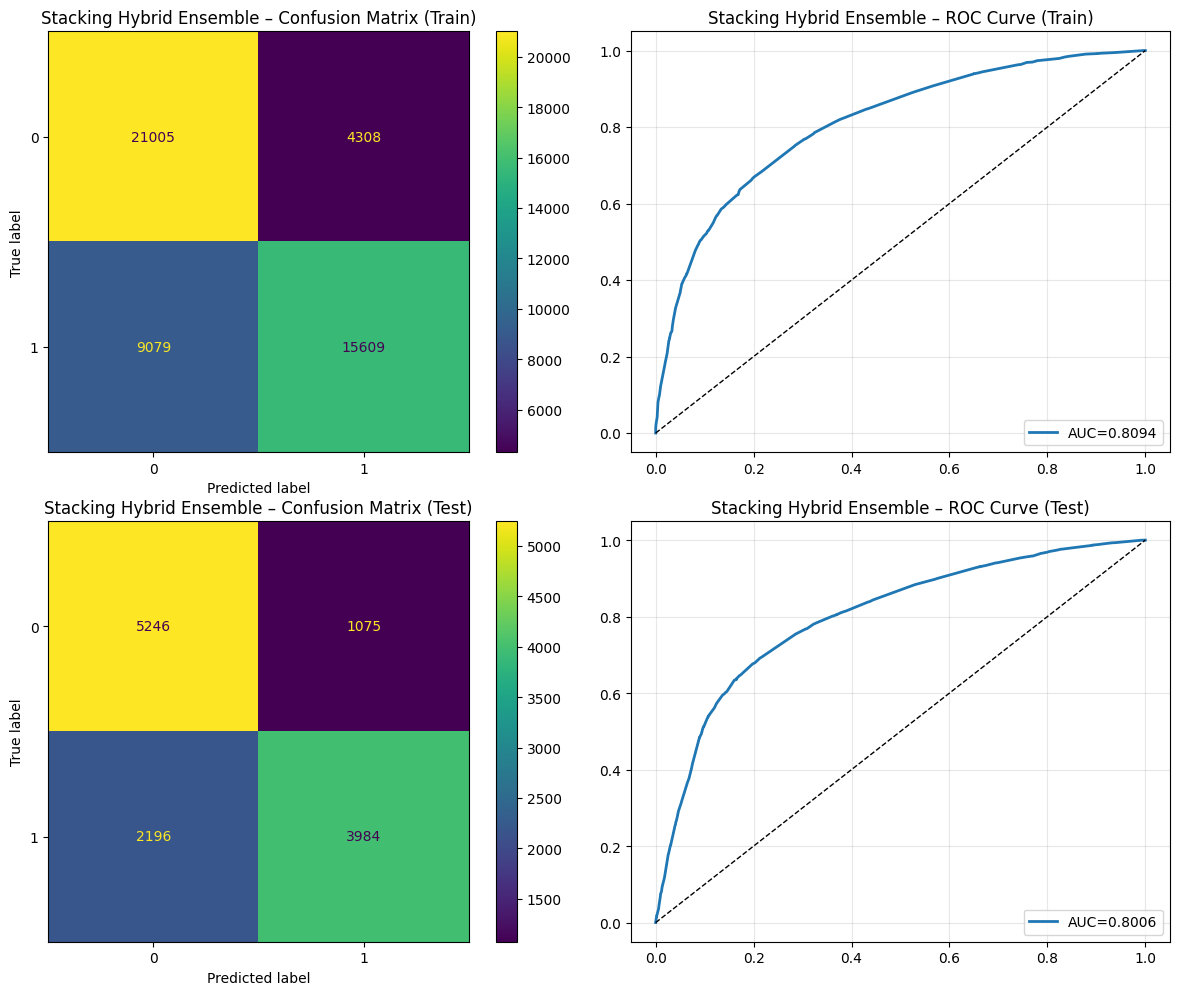

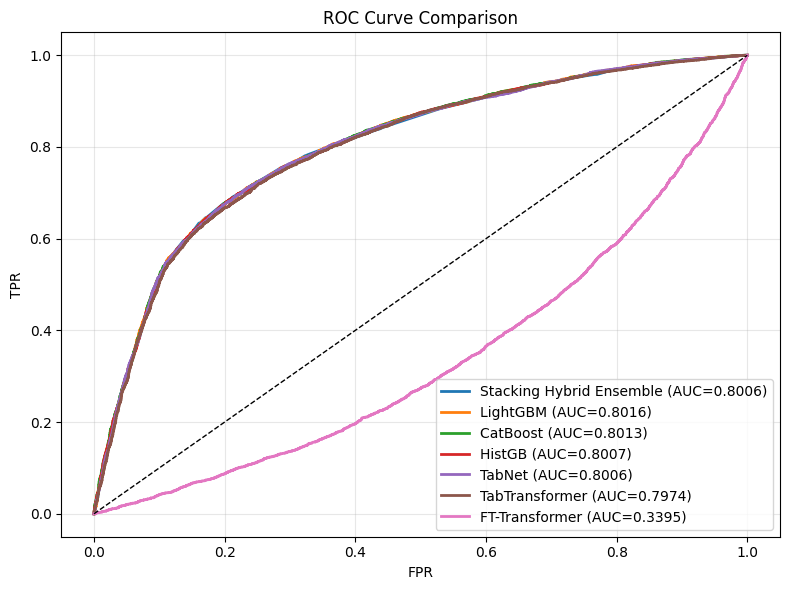

In [34]:
stacking_model_el_results = evaluate_model(
    model=stacking_model_el,
    x_train=x_train_np, y_train=y_train_np,
    x_test=x_test_np,  y_test=y_test_np,
    model_name='Stacking Hybrid Ensemble',
    label_mapping=label_mapping,
    categorical_indices=categorical_indices,
    continuous_indices=continuous_indices,
    comparison_models={
        'LightGBM': lgbm_model,
        'CatBoost': catb_model,
        'HistGB': hgrb_model,
        'TabNet': tabnet_model,            
        'TabTransformer': tabtf_wrapper,  
        'FT-Transformer': fttf_wrapper    
    }
)


stacking_model_el_results;


===  Results ===
Test   Acc: 0.7383, AUC: 0.8006
              precision    recall  f1-score   support

           0     0.7049    0.8299    0.7623      6321
           1     0.7875    0.6447    0.7090      6180

    accuracy                         0.7383     12501
   macro avg     0.7462    0.7373    0.7356     12501
weighted avg     0.7457    0.7383    0.7359     12501

Train   Acc: 0.7323, AUC: 0.8094
              precision    recall  f1-score   support

           0     0.6982    0.8298    0.7583     25313
           1     0.7837    0.6323    0.6999     24688

    accuracy                         0.7323     50001
   macro avg     0.7410    0.7310    0.7291     50001
weighted avg     0.7404    0.7323    0.7295     50001

✅ No significant overfitting



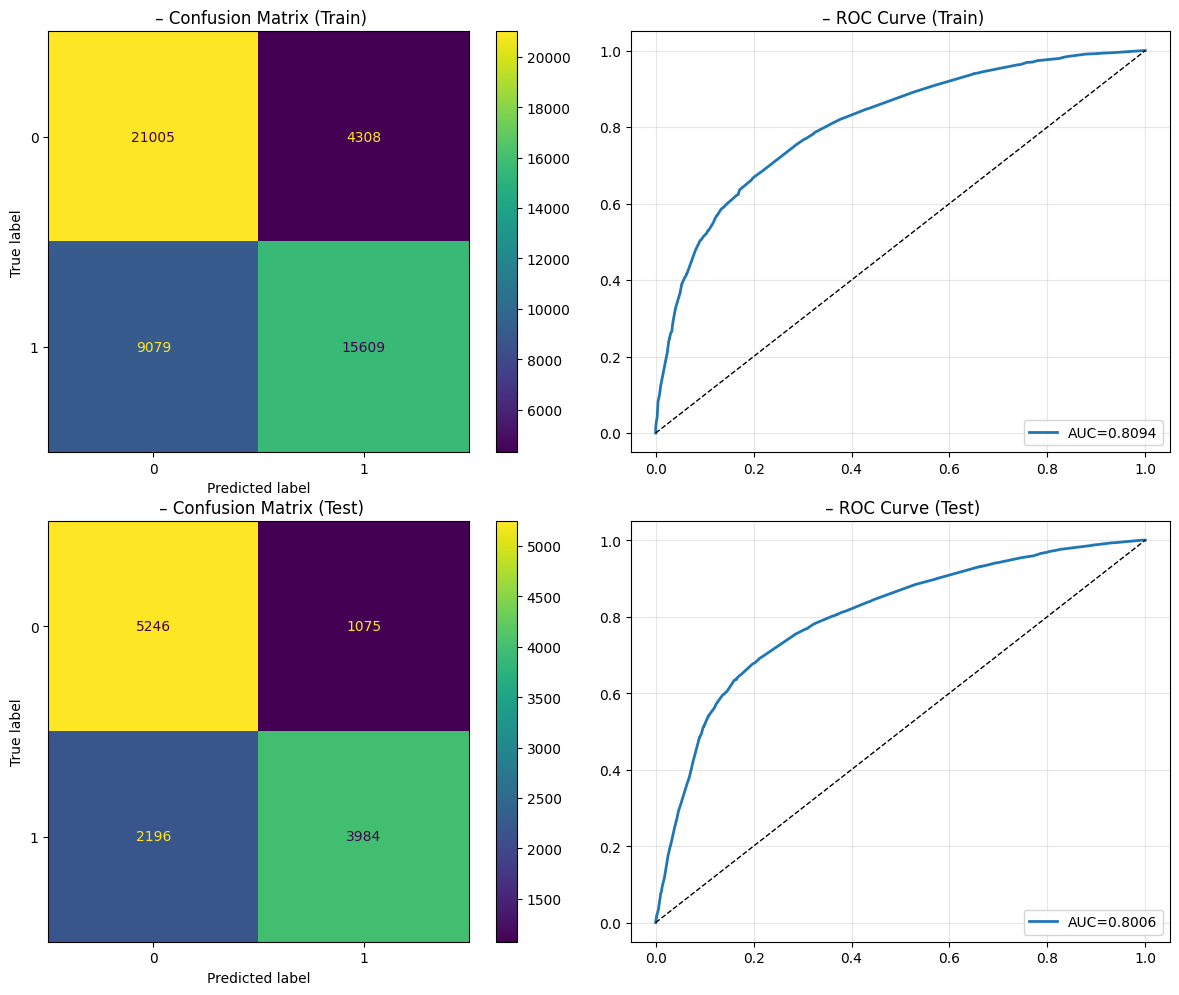

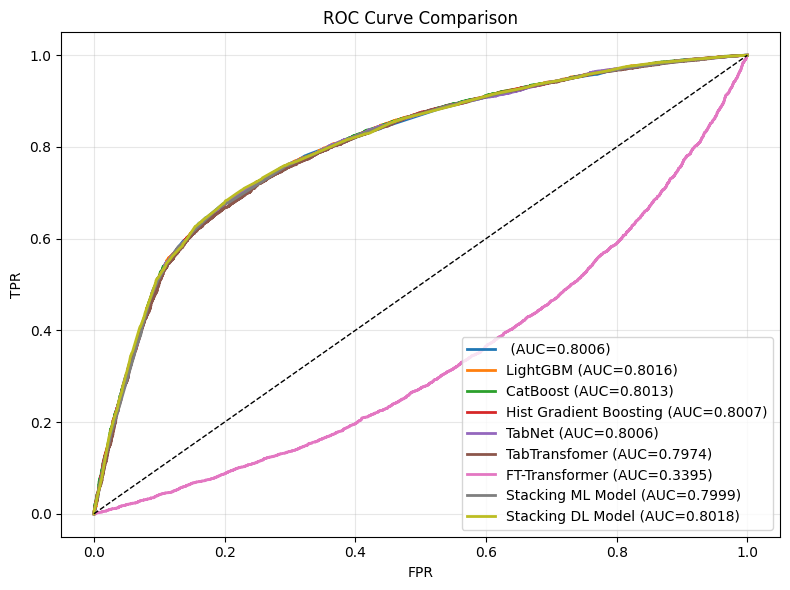

In [35]:
stacking_model_el_results = evaluate_model(
    model=stacking_model_el,
    x_train=x_train_np, y_train=y_train_np,
    x_test =x_test_np,  y_test =y_test_np,
    name='Stacking Hybird Ensemble Model',
    label_mapping=label_mapping,
    cat_indices=categorical_indices,
    cont_indices=continuous_indices,
    comparison_models={'LightGBM': lgbm_model, 'CatBoost': catb_model, 'Hist Gradient Boosting': hgrb_model, 
                    'TabNet':tabnet_model, 'TabTransfomer': tabtf_wrapper, 'FT-Transformer': fttf_wrapper, 
                    'Stacking ML Model': stacking_model_ml, 'Stacking DL Model':stacking_model_dl}
)


stacking_model_el_results;

In [ ]:
# y_pred = stacking_model.predict(x_test_np)

# accuracy = accuracy_score(y_test_np, y_pred)
# report = classification_report(y_test_np, y_pred)

# print("Accuracy:", accuracy)
# print("\nClassification Report:\n", report)

Accuracy: 0.8847179487179487

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      4974
           1       0.90      0.86      0.88      4776

    accuracy                           0.88      9750
   macro avg       0.89      0.88      0.88      9750
weighted avg       0.89      0.88      0.88      9750



In [ ]:
# import numpy as np
# from scipy.stats import pearsonr

# # Misal, prediksi probabilitas dari base model disimpan dalam dictionary
# # Prediksi base model harus berupa array 1 dimensi (misalnya, probabilitas kelas positif)
# preds_lgbm = lgbm_model.predict_proba(x_test_np)[:, 1]
# preds_cat = catb_model.predict_proba(x_test_np)[:, 1]
# preds_hgrb = hgrb_model.predict_proba(x_test_np)[:, 1]
# preds_tabnet = tabnet_model.predict_proba(x_test_np)[:, 1]

# # Menyimpan semua prediksi di dalam array
# all_preds = np.vstack([preds_lgbm, preds_cat, preds_hgrb, preds_tabnet])

# # Menghitung korelasi antar model
# n_models = all_preds.shape[0]
# for i in range(n_models):
#     for j in range(i+1, n_models):
#         corr_coef, _ = pearsonr(all_preds[i], all_preds[j])
#         print(f"Korelasi antara model {i} dan model {j}: {corr_coef:.3f}")


Korelasi antara model 0 dan model 1: 0.992
Korelasi antara model 0 dan model 2: 0.998
Korelasi antara model 0 dan model 3: 0.989
Korelasi antara model 1 dan model 2: 0.991
Korelasi antara model 1 dan model 3: 0.983
Korelasi antara model 2 dan model 3: 0.989


In [ ]:
# numerical_features = ['age', 'height', 'weight', 'systolic', 'diastolic', 'bmi', 'map', 'pulse_pressure']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features)
#     ],
#     remainder='passthrough' 
# )

# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', stacking_model)
# ])

# pipeline.fit(X_train, y_train)

# with open("pkl/ml_ensemble_model.pkl", "wb") as f:
#     pickle.dump(pipeline, f)

# print("Pipeline telah disimpan dalam file 'ml_ensemble_model_v2.pkl'.")

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/sit

Pipeline telah disimpan dalam file 'ml_ensemble_model_v2.pkl'.


In [ ]:
# with open('pkl/ml_ensemble_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# # Lakukan prediksi menggunakan CPU
# y_pred = loaded_model.predict(X_test)

# # Menghitung dan menampilkan accuracy score
# acc = accuracy_score(y_test, y_pred)
# print("Akurasi model:", acc)

Akurasi model: 0.8832820512820513


In [ ]:
# data_new = {
#     'age':       [30, 35, 40, 45, 50, 60, 65, 70, 55, 68],   
#     'height':    [175, 180, 170, 165, 160, 158, 155, 150, 165, 160], 
#     'weight':    [68, 75, 72, 80, 85, 90, 95, 100, 78, 82], 
#     'systolic':  [110, 115, 120, 125, 130, 140, 150, 160, 115, 135],  
#     'diastolic': [70, 75, 80, 85, 90, 95, 100, 105, 75, 88],         
#     'gender':       [0, 0, 1, 0, 1, 1, 1, 1, 0, 1], # gender: 0 untuk nilai asli 1, 1 untuk nilai asli 2
#     'cholesterol':  [0, 0, 1, 1, 2, 2, 2, 2, 0, 2], # cholesterol: 0 untuk nilai asli 1, 1 untuk nilai asli 2, 2 untuk nilai asli 3
#     'gluc':         [0, 0, 1, 1, 1, 2, 2, 2, 0, 2], # gluc: 0 untuk nilai asli 1, 1 untuk nilai asli 2, 2 untuk nilai asli 3
#     'smoke':        [0, 0, 0, 0, 1, 1, 1, 1, 0, 1],
#     'alco':         [0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
#     'active':       [1, 1, 1, 1, 0, 0, 0, 0, 1, 0]
# }

# new_df = pd.DataFrame(data_new)

# valid_gender      = new_df['gender'].isin([0, 1])
# valid_cholesterol = new_df['cholesterol'].isin([0, 1, 2])
# valid_gluc        = new_df['gluc'].isin([0, 1, 2])
# valid_smoke       = new_df['smoke'].isin([0, 1])
# valid_alco        = new_df['alco'].isin([0, 1])
# valid_active      = new_df['active'].isin([0, 1])

# if not (valid_gender.all() and valid_cholesterol.all() and valid_gluc.all() and 
#         valid_smoke.all() and valid_alco.all() and valid_active.all()):
#     raise ValueError("Terdapat nilai kategori yang tidak valid pada input data.")

# new_df["bmi"] = round(new_df["weight"] / ((new_df["height"] / 100) ** 2), 2)
# new_df["map"] = round((new_df["systolic"] + 2 * new_df["diastolic"]) / 3, 2)
# new_df["pulse_pressure"] = new_df["systolic"] - new_df["diastolic"]

# expected_order = [
#     'age', 'height', 'weight', 'systolic', 'diastolic', 
#     'bmi', 'map', 'pulse_pressure',
#     'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'
# ]
# new_df = new_df[expected_order]

# with open("pkl/ml_ensemble_model.pkl", "rb") as f:
#     pipeline = pickle.load(f)

# predictions = pipeline.predict(new_df)

# print("Input Data Baru (setelah pembuatan fitur turunan dan validasi):")
# print(new_df)
# print("\nHasil Prediksi untuk 10 contoh data:")
# print("Prediksi status cardio untuk data baru:", predictions)


In [ ]:
# stacking_results = evaluate_model(stacking_model, x_train_np, y_train, x_test_np, y_test, "Stacking Ensemble Classifier")
# stacking_results;

In [ ]:
# results = [lgbm_results, xgb_results, catb_results, 
#         snb_results, grb_results, hgrb_results, stacking_results
#         ]

# create_summary_table(results)